# Advances in Machine Learning with Big Data

### Trinity 2021
### Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 5]

import sys, os
from mpl_toolkits.mplot3d import axes3d
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.pipeline import make_pipeline

import sbs_visualize    # module where I've put some functions from the last class
import sbs_sklearn
from uci_retail_data import uci_files, stock_codes

Populating the interactive namespace from numpy and matplotlib


## 8. Neural networks

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. Classification

1. Decision trees, bagging, and random forests

1. **Make a start on neural networks**

Load data per previous classes ...

In [2]:
df = uci_files.standard_uci_data_access()

2021-05-17 16:09:47,385 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2021-05-17 16:09:50,149 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [3]:
invalids = stock_codes.invalid_series(df)

In [4]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

Prepare our dataset for linear regression:

In [5]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

y = invoices.log_item_spend
X = invoices[predictors] 

Prepare to do visualization of results:

In [6]:
def prediction(l, w, predictor):
    """
    @param predictor: a method such as LinearModel().predict
    for given l and w, we return the prediction at the configured hour and month
    """
    two_d_array = np.array( [l, sbs_visualize.HOUR, sbs_visualize.MONTH, w] )[None, :]
    return predictor(two_d_array)

In [7]:
def set_todays_labels(axs):
    axs.set_xlabel(X.columns[0].strip("log_"))
    axs.set_ylabel(X.columns[-1])
    axs.set_zlabel(y.name.strip("log_"))

In [8]:
def evaluate_model(model, model_name, comment='', train_on_monority=False):
    scores = sbs_sklearn.train_n_test(X, y, N_FOLDS, 
                                      train_on_minority=train_on_monority, 
                                      update_frequency=9,
                                      model=model)
    sbs_sklearn.plot_kfold_scores(scores)
    plt.show()

    surf = np.vectorize(prediction)(sbs_visualize.GRID_X, 
                                         sbs_visualize.GRID_Y, 
                                         model.predict)
        
    ax = sbs_visualize.threeDplot(a = np.exp(sbs_visualize.GRID_X), 
                                  b = sbs_visualize.GRID_Y, 
                                  c = np.exp(surf), 
                                  model_name = "last fitted " + model_name)
    set_todays_labels(ax)

## Implement first Neural Net

In [9]:
from sklearn import neural_network

#### First - a recap of some method we have seen

In [10]:
N_FOLDS = 25

In [11]:
elasticCV = make_pipeline(preprocessing.PolynomialFeatures(include_bias=False, degree=4),
                          preprocessing.StandardScaler(),
                          linear_model.ElasticNetCV(l1_ratio=[.1, .5, .75, .95]))

2021-05-17 16:10:01,493 INFO:Study 1/25: 19753 train rows;  824 test rows
2021-05-17 16:10:52,451 INFO:Study 10/25: 19754 train rows;  823 test rows
2021-05-17 16:11:44,016 INFO:Study 19/25: 19754 train rows;  823 test rows


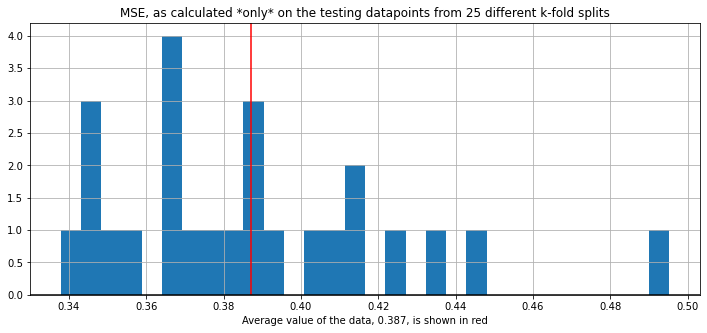

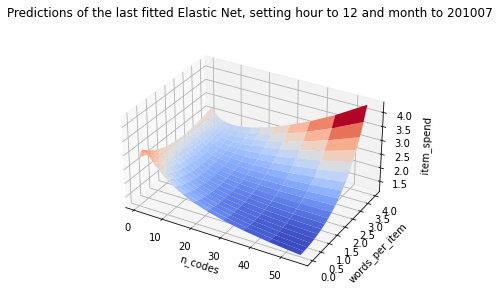

In [12]:
evaluate_model(elasticCV, 'Elastic Net', comment='')

In [13]:
random_forest = ensemble.RandomForestRegressor(min_weight_fraction_leaf=0.1, 
                                               max_samples=0.1,   # each Bootstrap takes 10% of the data
                                               n_estimators=1000) # number of trees

2021-05-17 16:12:31,143 INFO:Study 1/25: 19753 train rows;  824 test rows
2021-05-17 16:12:59,005 INFO:Study 10/25: 19754 train rows;  823 test rows
2021-05-17 16:13:21,803 INFO:Study 19/25: 19754 train rows;  823 test rows


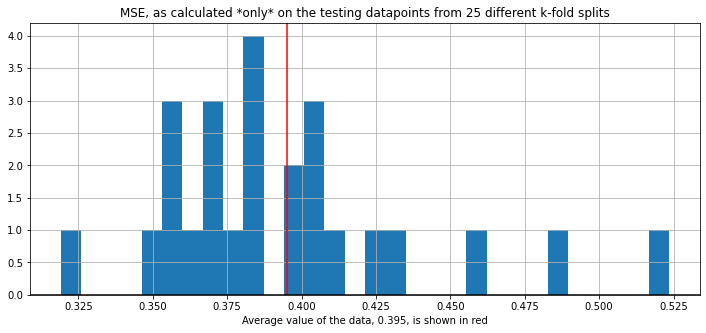

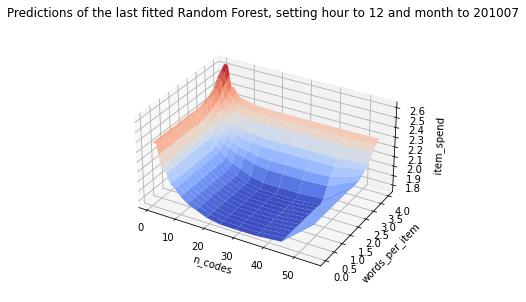

In [14]:
evaluate_model(random_forest, 'Random Forest', comment='')

First look at the Neural Net:

In [15]:
nnp = make_pipeline(preprocessing.StandardScaler(),
                    neural_network.MLPRegressor(hidden_layer_sizes=(20,))  )

2021-05-17 16:14:07,163 INFO:Study 1/25: 19753 train rows;  824 test rows
2021-05-17 16:14:33,778 INFO:Study 10/25: 19754 train rows;  823 test rows
2021-05-17 16:14:55,549 INFO:Study 19/25: 19754 train rows;  823 test rows


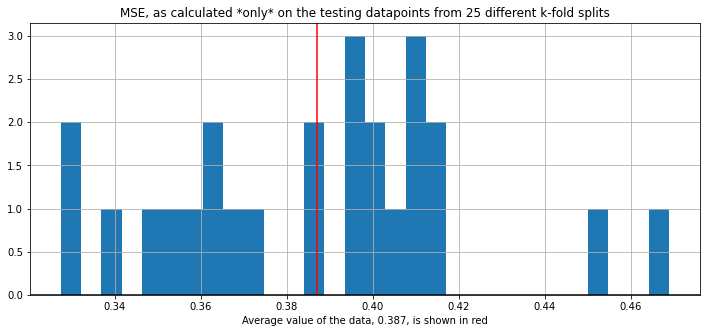

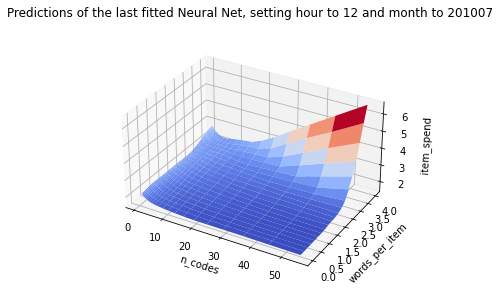

In [16]:
evaluate_model(nnp, 'Neural Net', comment='')

In [17]:
# group = ensemble.StackingRegressor(estimators=[('elasticCV', elasticCV), 
#                                                ('random_forest', random_forest),
#                                                ('nnp', nnp),])

# evaluate_model(group, 'ensemble', comment='mix every method together')

## Defining single-layer Neural Nets

#### Toward Neural Nets: the Projection Pursuit

*The Elements of Statistical Learning* Ch. 11

We have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in moments of the R.V. $y_i$, conditional on the multivariate R.V.  $x_i$ (of length, say, $p$). 

Linear regression:

\begin{equation}
y_i = x_i ' \beta + \epsilon_i,
\end{equation}
where $\beta$ is a vector of parameters of length $p$, and the i.i.d. sequence of random variables $\{\epsilon_i\}$ is independent of the regressors $\{x_i\}$

Evidently, it is futile to postulate 'stacking' several of these:

\begin{equation}
y_i = x_i ' \beta_1 + x_i ' \beta_2 + x_i ' \beta_3 + ... + \epsilon_i,
\end{equation}
where each $\beta_j$ is a vector of parameters of length $p$.

**Discussion**: why?

However, this is *not futile* if we apply a non-linear transformation to each of these components.

So, let $g_j()$ be a collection of univariate [for now] & monotone but, crucially, **not linear**, functions:

\begin{equation}
y_i = g_1\left(x_i ' \beta_1\right) + g_2\left(x_i ' \beta_2\right) + ... + g_M\left(x_i ' \beta_M\right) + \epsilon_i,
\end{equation}

This is known as *Projection Pursuit*, where
* $g_j$ are called *ridge functions*.
* $x_i ' \beta_1$ is a *projection* of the $ith$ predictors onto a 1d vector, $\beta_1$

#### Some example projection pursuits

In [18]:
a, b = np.mgrid[-1: 1: 80j, -1: 1: 80j]

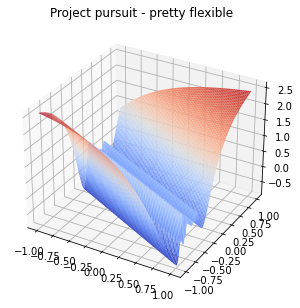

In [19]:
ax = plt.figure().add_subplot(111, projection="3d")
V = a + 2 * b
surf = (V + .1) * np.sin(1/(V/3 + 0.1))
ax.plot_surface(a, b, surf, cmap="coolwarm", rstride=1, cstride=1)
_ =  plt.title("""Project pursuit - pretty flexible """)

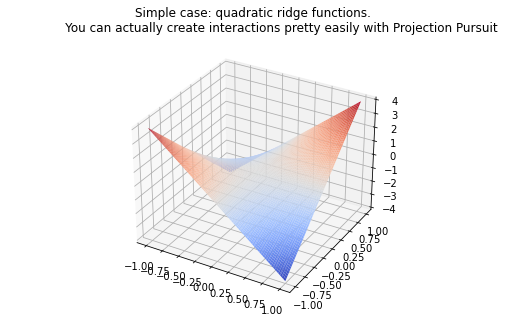

In [20]:
ax = plt.figure().add_subplot(121, projection="3d")
surf = (a + b)**2 - (a - b)**2
ax.plot_surface(a, b, surf, cmap="coolwarm", rstride=1, cstride=1)
_ =  plt.title("""Simple case: quadratic ridge functions.
               You can actually create interactions pretty easily with Projection Pursuit""")

In this example, we use the *same* $g()$ twice. This symmetry doesn't matter: we get a lot of flex.

In fact, make $M$ big enough, and you can approximate any continuous function.

On the other hand, $g()$ can be pretty simple ...

#### Rectified Linear Unit (rectifier)

From now on, we'll mainly apply a single, very simple, $g()$:

In [21]:
def reLU(z):
    # Rectifier
    return np.max([z, z * 0], axis=0)

So: $g$ is `reLU`, ie $g_m(z) = \eta_m max(z, 0)$. 

(the constant parameter $\eta_m$ lets the `reLU` go negative, and later it will be often be a vector ...)

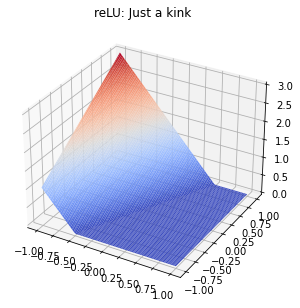

In [22]:
ax = plt.figure().add_subplot(111, projection="3d")
ax.plot_surface(a, b, reLU(b - 2 * a), cmap="coolwarm", rstride=1, cstride=1)
_ =  plt.title("""reLU: Just a kink""")

(Must go through (0, 0, 0). Too stringent: so, if we are going to do this, we had better include an intercept in $x_i$)

Building a ReLU function into Projection Pursuit:

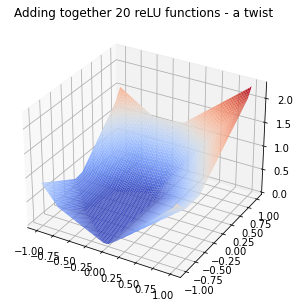

In [23]:
def twist_relu(i):
    return reLU(a * np.cos(i) + b * np.sin(i) - i/5)

relus = [twist_relu(j) for j in range(20)]

surf = np.sum(relus, axis=0)
ax = plt.figure().add_subplot(111, projection="3d")
ax.plot_surface(a, b, surf, cmap="coolwarm", rstride=1, cstride=1)
_ =  plt.title("""Adding together 20 reLU functions - a twist""")

#### Neural Nets defined

With this in mind, lets read the scikit-learn [documentation](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) on neural nets.

**Exercise**: Review how [this diagram](https://scikit-learn.org/stable/_images/multilayerperceptron_network.png) should be adjusted to fit the 'twist' example above. For this example,
* what function is $f$ ?
* how tall is the red column of bubbles?
* how tall is the black column of bubbles?
* any other changes?

Vocabulary:

|projection pursuit|neural net|
|---|---|
|ridge function|activation function|
|$\beta_j$|$w_j$|
|coefficients|weights|
|intercept|bias|
|projection|neuron / unit / node|
|fitting|training|
|iteration|epoch|
|step size|learning rate|
|model in pipeline|layer|
|?|encoding|
|quadratic|L2|

Observation: 

The widespread adoption of the reLU activation function distanced the NN from the brain metaphor, which might have suggested $g(x) = I_{x > 0}$ [or something similar but smoother].

### Training a Neural Net

*The Elements of Statistical Learning* 11.4

Plan:
1. Gradient Descent
1. Stochastic Gradient Descent, and link to boosting
1. ADAM algorithm
1. Backpropagation and GPU technology
1. [sklearn.neural_network.MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

### Gradient Descent

We know that the OLS estimate, $\hat\beta$, of a linear regression is $(X'X)^{-1}X'Y$. As long as we can invert matrices, we don't have to iterate to that solution.

But we could proceed iteratively, too. We would need:
* a small $\lambda>0$, a tuning parameter known as the *step size* / *learning rate*, and 
* a first guess at $\hat\beta$, however bad. Call this $\hat\beta_0$.

Then we say:
1. "*forward pass*": given the current $\hat\beta_t$, compute $\hat\epsilon_t$ and $\hat Y_t$.
1. define the gradient, $\gamma_t$, as $-2X'{\hat\epsilon_t}$
1. move from $\hat\beta_t$ to $\hat\beta_{t+1}$ by subtracting $\lambda \gamma_t$
1. repeat this, until such time, $t$, as the improvement in MSE is very meagre.

> Geometric intuition: if at time $t$ there's still a positive correlation between a feature and the residuals, we 'nudge up' (increase) the coefficient on that feature.

This will get to $\hat\beta$. It has some advantages:
* it converges, even if parameters are not identified, e.g. if $X$ is collinear.
* it can be applied to projection pursuit about as easily. I will now illustrate this in the easiest case. 

Suppose we are fitting a single reLU function, $g()$, so:
\begin{equation}
Y = g(X\beta_1) + \epsilon,
\end{equation}
then gradient descent here corresponds to:

1. "*forward pass*": given the current $\hat\beta_t$, compute $\hat\epsilon_t$ and $\hat Y_t$.
1. define the gradient, $\gamma_t$, as $-2\left(XI_{\hat Y_t \neq 0}\right)'{\hat\epsilon_t}$
    * the bit in the bracket zeros-out any rows of $X$ that give zero-forecast after the reLU.
    
1. then define $\hat\beta_{t+1} = \hat\beta_{t} - \lambda \gamma_t$
1. move from time $t$ to $(t+1)$, repeat, but stop once the gain in MSE is meagre.

### [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

If $(Y, X)$ is a huge dataset, it may make computational sense not to load it all into memory. 

Instead, access it one datapoint at a time. So, the Gradient Descent algorithm in our reLU example is replaced by:

1. pick at random a single element from $(Y, X)$, call it $(y^i, x^i)$
    * "*forward pass*": given the current $\hat\beta_t$, compute $\hat\epsilon^i_t$ and $\hat y^i_t$ 

1. If $\hat y^i_t \neq 0$, define the stochastic gradient, $\gamma_t$, as $-2x^i\hat\epsilon^i_t$
    * otherwise $\gamma_t$ is just 0
    
1. then define $\hat\beta_{t+1} = \hat\beta_{t} - \lambda \gamma_t$
1. move from time $t$ to $(t+1)$, repeat, but stop once the gain in MSE is meagre.

**Observations about SGD**

We injected randomness into fitting. This regularizes; it also means that improvement in MSE is **not monotone**. 
* Two steps forward, one step back. Still worth doing.

In practice, NNs are normally fitted take several observations at a time, called a *mini-batch* (or sometimes, just *batch*)
* not just SGD one-at-a-time.
* recall: we had a first look at mini-batches in the case of a Random Forest, where at one point we fitted each tree on a mini-batch. This helped to decorrelate the trees.

We call an *epoch* the time taken until each datapoint has been used once (in expectation). Works both for mini-batch and for one-at-a-time approaches.

### [ADAM](https://arxiv.org/abs/1412.6980)


Adaptation to Stochastic Gradient Descent:
* In a 'smoothed' version of batching, we adjust Step 3 by replacing $\gamma_t$ with an EWMA smooth of $\gamma_t$ across elapsed time, lets call this smooth $\hat m_t$.

ADAM goes further, by also maintaining a smooth of $\gamma_t^2$ (the componentwise square of $\gamma_t$), call this $\hat v_t$.

By comparing $\hat m_t$ to $\hat v_t$ , it can 'dampen-down' jitter in high-variance parameter-estimates.

This stabilises things for other parameters.

ADAM, applied to the fitting of the reLU, would approximately be:
 
1. pick at random a single element from $(Y, X)$, call it $(y^i, x^i)$
    * "*forward pass*": given the current $\hat\beta_t$, compute $\hat\epsilon^i_t$ and $\hat y^i_t$ 

1. If $\hat y^i_t \neq 0$, define the stochastic gradient, $\gamma_t$, as $-2x^i\hat\epsilon^i_t$
    * otherwise $\gamma_t$ is 0
    * update the 'smooths', $\hat m_t$ and $\hat v_t$, using this fresh value of $\gamma_t$.
    
1. then define $\hat\beta_{t+1} = \hat\beta_{t} - \lambda \frac{\hat m_t}{\sqrt{\hat v_t}}$

1. move from time $t$ to $(t+1)$, repeat, but stop once the gain in MSE is meagre.

### Backpropagation

Above, we described how to calculate the gradient, $\gamma_t$, for the most basic case - of fitting a single reLU.

Now suppose we had 100 reLUs in our neural net.
* Whether SGD or ADAM, the approach above unchanged, except Step 2. Here we need to derive $\gamma_t$ as a sum of 100 parts.

* More generally, we apply the additive, chain, and product rules of differentiation ;

* we apply them 'backwards' through the [network](https://scikit-learn.org/stable/_images/multilayerperceptron_network.png) ;

* this derives $\gamma_t$ in preparation for Step 2. 


* The problem here is mainly juggling simple, but long, algebraic expressions. 

Code can and does help. Repeating a pre-cooked computation of $\gamma_t$ is known as [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

Generally, fitting programs take the form of *forward-pass*, followed by *backpropagation*; repeat.

GPUs turn out to be very good at this ([2nd para here](https://en.wikipedia.org/wiki/Graphics_processing_unit#Computational_functions); [thoughts from Nvidia](https://devblogs.nvidia.com/even-easier-introduction-cuda/)).

### [sklearn.neural_network.MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

Lets take a [look](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html). We find some additional bells/whistles options in the scikit-learn implementation:
* [L2 regularization](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regularization) (ridge on the parameters)

* max_iter (default=200)
    * iterates until convergence or this number of epochs
    * regularization, by not over-computing

* option not to shuffle samples at each iteration

* [warm start](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#more-control-with-warm-start)
    * If true, to intialize the algorithm, reuse the solution of the previous call-to-fit (if any)

* early stopping regularization
    * set aside 10% of training data for validation:
    * terminate training when validation score is not improving.

### Kicking the tires on a Neural Net

In [24]:
nnp = make_pipeline(preprocessing.StandardScaler(),
                    neural_network.MLPRegressor(hidden_layer_sizes=(100, 100), alpha=1e-3, warm_start=True  ))

2021-05-17 16:15:17,929 INFO:Study 1/25: 19753 train rows;  824 test rows
2021-05-17 16:16:06,103 INFO:Study 10/25: 19754 train rows;  823 test rows
2021-05-17 16:16:17,869 INFO:Study 19/25: 19754 train rows;  823 test rows


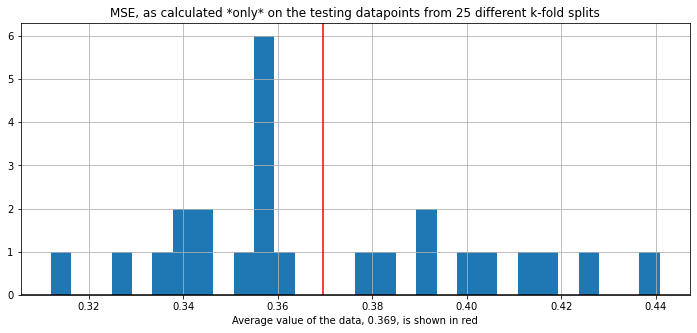

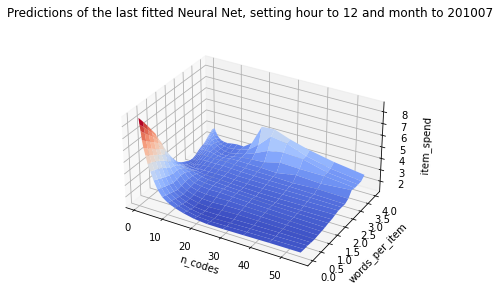

In [25]:
evaluate_model(nnp, 'Neural Net', comment='')

**Exercise:** There is something very wrong here - what?